In [1]:
%pylab inline
import scipy
from pyiga import bspline, assemble, geometry, vis

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


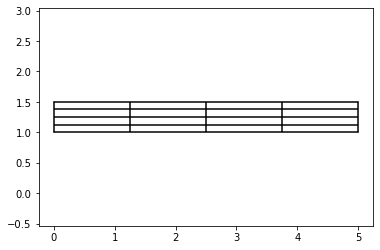

In [2]:
# define geometry
# undeformed stick
geo = geometry.tensor_product(geometry.line_segment(1,1.5), geometry.line_segment(0,5, intervals=3))
vis.plot_geo(geo, grid=5)
axis('equal');

In [3]:
#n_el = (50, 25)   # number of elements in y/x direction
n_el = (50, 10) # istotropic material

# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)
#Mu = 0.003 * 1e+9 #300000 #0.003*10^9 #(shear modulus, rubber: 0.003 GPa)
#Lam= 0.00028416 * 1e+9 #284160 #0.00028416*10^9 # [Pa]

def linelast_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(2,2)) # vector valued
    e_u = 1/2 * (grad(u) + grad(u).T)
    e_v =  1/2 * (grad(v) + grad(v).T)
    vf.add(2* Mu *inner(e_u,e_v) * dx)
    return vf

In [4]:
# define Dirichlet boundary conditions
def g_def(x, y):  return (0.0, (1-y)*(1.5-y)) 
def g_zero(x, y): return (0.0, 0.0)

def g0(x,y):
    if (x>4).all():
        return -3e-7 # set force at distal end only
    else:
        return 0
    
def g(x,y):
    #print(x)
    if isinstance(x,numpy.float64):
        return (0,g0(x,y))
    return (0,[g0(xi,0) for xi in np.nditer(x)])



In [5]:
# rhs
f = lambda x,y: (0,0) # source term

In [6]:
xgrid = linspace(0, 1, 20)
xygrid = (xgrid, xgrid) 

G = geo.grid_eval(xygrid)

In [7]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

In [8]:
## define isogeometric Taylor-Hood discretization space
#p = 3    # spline degree of displacement space

def func_p(p, geo, n_el, xygrid):
# displacement space: degree p,   continuity p-1
# "pressure" space: degree p-1, continuity p-2
    kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=1) for n in n_el)
    kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)
    m_u = tuple(kv.numdofs for kv in kvs_u)
    
    # assemble the System matrix
    A_div  = -assemble.assemble('div(u) * p * dx', (kvs_u, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo)
    A_grad = assemble.assemble_vf(linelast_vf(2), kvs_u, geo=geo, symmetric=True)
    A_c  = assemble.assemble('p * q * dx', kvs_p, bfuns=[('p',1,0), ('q',1,0)], geo=geo)/Lam

    A_lin_el = scipy.sparse.bmat(
    [[A_grad, A_div.T],
     [A_div,  -A_c]], format='csr')
    
    # set inhom. Neumann cond. on distal end, hom. NBC elsewhere
    bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
                                         [('left', g_zero)])# left: dirichlet boundary cond.
    
    gn= assemble.assemble('inner(g,v)*ds', kvs_u, bfuns=[('v',2)], geo=geo, g=g, boundary='top')
    g2= assemble.boundary_dofs(kvs_u,'top',ravel=True) # gives us all boundary dofs

    # incorporate neumnann boundary condition
    shape_a= shape(A_grad)[0]# at boundary = 0 , only in 2nd component
    nbc= np.zeros(shape(A_lin_el)[0])
    for i in range(len(g2)):
        nbc[g2[i]]= gn[0,0,i] #gn[0,i,0],gn[0,0,i]
        nbc[g2[i]+shape_a//2]= gn[1,0,i] #gn[1,i,0], gn[1,0,i]

    rhs = assemble.inner_products(kvs_u, f, f_physical=True, geo=geo).ravel()
    # reshape rhs
    rhs= np.pad(rhs, (0,shape(A_c)[0]))

   # solve Linear elasticity problem with the given boundary conditions and 0 right-hand side
    LS = assemble.RestrictedLinearSystem(A_lin_el, rhs+nbc, bcs) 
    u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
    u = LS.complete(u)
    
    # split the solution into its components (displacement in x- and y-coord.)
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)
    u2 = u[N:2*N].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    displ = geometry.BSplineFunc(kvs_u, U) # construct function with input arguments: coeff, basis functions (kvs), u_hat(x)
    dis = displ.grid_eval(xygrid)
    return dis


Compiling /home/hilbert/heigl/.cache/pyiga/modules/mod0df69376dd763ee1.pyx because it changed.
[1/1] Cythonizing /home/hilbert/heigl/.cache/pyiga/modules/mod0df69376dd763ee1.pyx


In file included from /home/hilbert/heigl/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/hilbert/heigl/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/hilbert/heigl/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/hilbert/heigl/.cache/pyiga/modules/mod0df69376dd763ee1.c:717:
/home/hilbert/heigl/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


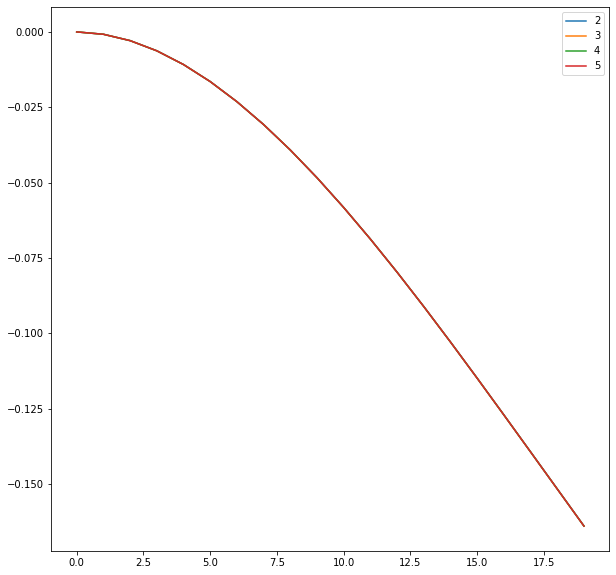

In [9]:
figsize(10,10)

for pp in range(2,6):
    dis= func_p(pp, geo, n_el, xygrid)
    y_val=[]
    for i in range(len(dis)):
        y_val = np.append(y_val,dis[0,i,1])
    plot(y_val, label=pp )
    
plt.legend()
plt.show()

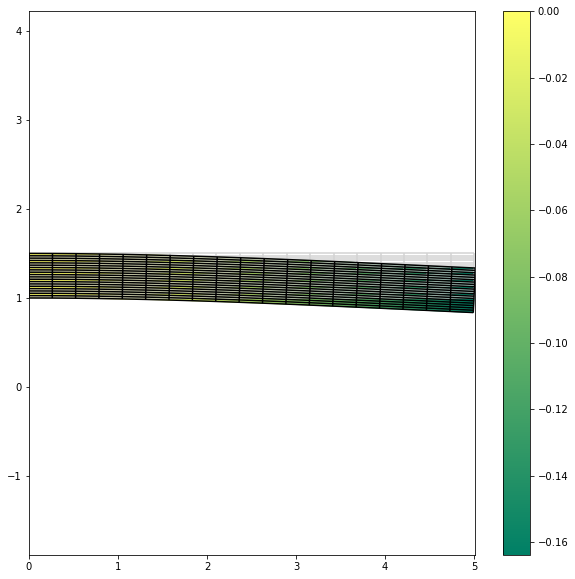

In [10]:
# plot deformation
#plt.subplot(226)
figsize(10,10)
fig, ax = plt.subplots()

dis= func_p(3, geo, n_el, xygrid)
plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")
plot_grid(G[...,0]+dis[...,0], G[...,1]+dis[...,1], ax=ax, color="black")

# colormesh w.r.t. displacement & deformed geometry
pcolormesh(G[...,0]+dis[...,0], G[...,1]+dis[...,1], dis[...,1], cmap='summer', shading='gouraud');
colorbar();

axis('equal');

In [11]:
def_x=(dis[...,0][19][19])
def_y = (dis[...,1][19][19])

G_x=(G[...,0][19][19])
G_y = (G[...,1][19][19])

xy= (G_x -def_x, G_y - def_y)
print(xy)


(4.988324645897771, 1.66391034909296)


In [12]:
h_rate = numpy.linspace(10, 50, 9)
print(h_rate)

y_val=np.zeros(len(h_rate))



[10. 15. 20. 25. 30. 35. 40. 45. 50.]


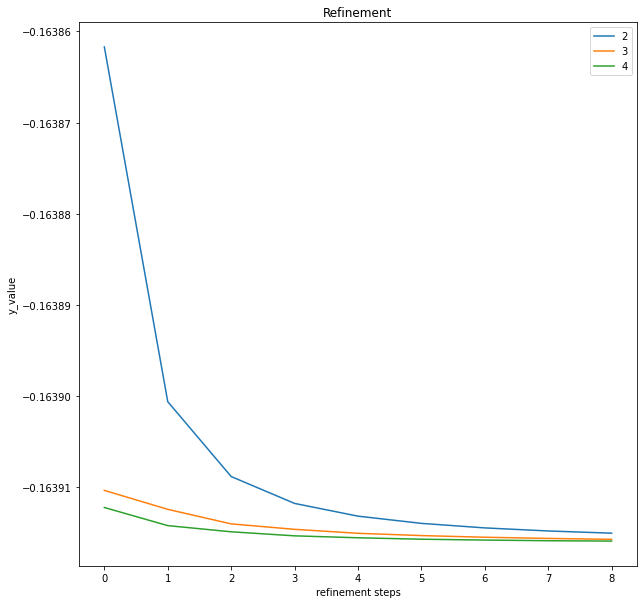

In [14]:
figsize(10,10)
l_idx=len(xgrid)-1 # last index

for pp in range(2,5):
    for i in range(0, len(h_rate)):
        n_el = (5*h_rate[i], h_rate[i]) #5:1
        dis= func_p(pp, geo, n_el, xygrid) 
        def_y = (dis[...,1][l_idx][l_idx])
        y_val[i] = def_y
    plt.plot(y_val, label =pp)
       

plt.title('Refinement')
plt.xlabel('refinement steps')
plt.ylabel('y_value')

plt.legend()
plt.show()
